#**Bangkit Final Project: Expression Classification with Machine Learning**

Repository :
https://github.com/AgilS121/Capstone-HealMentor

##Import Libraries

In [1]:
import zipfile
import os
import random
import math
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import metrics
from google.colab import files
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##Preparation Data with ETL (Extract, Transform, Load)

###Extract Dataset

Source dataset : https://www.kaggle.com/shawon10/ckplus

In [2]:
# Extract the downloaded zip file
local_zip = "/content/drive/MyDrive/Capstone/Capstone/CK+48.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

# Check the number of datasets
base_dir_ori = "/content/drive/MyDrive/Capstone/Capstone/CK+48"
label = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
list_ori_dir = [base_dir_ori+"/"+lb for lb in label]
for i in range(len(label)):
  print("Data {} : {}".format(label[i], len(os.listdir(list_ori_dir[i]))))

# Preparation of split by configuring directories
base_dir = "/tmp/data"
train_dir = base_dir + "/train"
test_dir = base_dir + "/test"
val_dir = base_dir + "/val"

try:
  # Create directory
  os.mkdir(base_dir)
  for par_dir in [train_dir, test_dir, val_dir]:
    os.mkdir(par_dir)
    for ch_dir in [par_dir+"/"+lb for lb in label]:
      os.mkdir(ch_dir)
  print("\nCreate directory successfully!")
except OSError as e:
  print("\nUnable create directory. {}".format(e))

Data anger : 135
Data contempt : 54
Data disgust : 177
Data fear : 75
Data happy : 207
Data sadness : 84
Data surprise : 249

Create directory successfully!


###Split Dataset

In [3]:
split = {
         'train' : 0.7,
         'test' : 0.15,
         'val' : 0.15
         }

def split_data(list_class_dir, train_dir, test_dir, val_dir, dict_split, label):
  # Split data for each class
  for idx_lb,class_dir in enumerate(list_class_dir):
    list_img = os.listdir(class_dir)
    list_img = random.sample(list_img, len(list_img))
    if (dict_split['train']+dict_split['test']+dict_split['val']==1.0):
      num_val = math.floor(dict_split['val'] * len(list_img))
      num_test = math.floor(dict_split['test'] * len(list_img))
      num_train = len(list_img) - num_val - num_test
      for i in range(len(list_img)):
        # Check image
        size_file_img = os.path.getsize(class_dir+"/"+list_img[i])
        if (size_file_img == 0):
          continue
        if (i < num_val):
          # Copy to val dir
          dest_dir = val_dir
        elif (i >= num_val and i < num_val + num_test):
          # Copy to test dir
          dest_dir = test_dir
        else:
          # Copy to train dir
          dest_dir = train_dir
        try:
          copyfile(class_dir+"/"+list_img[i], dest_dir+"/"+label[idx_lb]+"/"+list_img[i])
        except IOError as e:
          return "Unable to copy file. {}".format(e)
    else:
      return "Incorrect data split!"

    print("{} : train({}), test({}), val({})".format(
        label[idx_lb],
        len(os.listdir(train_dir+"/"+label[idx_lb])),
        len(os.listdir(test_dir+"/"+label[idx_lb])),
        len(os.listdir(val_dir+"/"+label[idx_lb]))
    ))

# Check the split results
split_data(
    list_class_dir=[base_dir_ori+"/"+lb for lb in label],
    train_dir=train_dir,
    test_dir=test_dir,
    val_dir=val_dir,
    dict_split=split,
    label=label
)

anger : train(95), test(20), val(20)
contempt : train(38), test(8), val(8)
disgust : train(125), test(26), val(26)
fear : train(53), test(11), val(11)
happy : train(145), test(31), val(31)
sadness : train(60), test(12), val(12)
surprise : train(175), test(37), val(37)


###Transform Dataset

Reference for batch size, epoch, and learning rate :
https://medium.com/syntaxerrorpub/what-are-steps-epochs-and-batch-size-in-deep-learning-5c942539a5f8

In [4]:
# Corresponds to a lot of data
batch_train = 32 # Alternative : 8,16,32,64
batch_val = 16
batch_test = 16
size_input = (224, 224)

# Normalize image
valtest_datagen = ImageDataGenerator(rescale=1./255.)

###Augmentation

Reference for augmentation :
https://keras.io/api/layers/preprocessing_layers/image_augmentation/

In [5]:
# Image augmentation (optional to improve accuracy)
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

###Load Dataset

In [6]:
# Train Generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=batch_train,
    class_mode='categorical',
    target_size=size_input
)

# Test Generator
test_generator = valtest_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=batch_test,
    class_mode='categorical',
    target_size=size_input
)

# Val Generator
val_generator = valtest_datagen.flow_from_directory(
    directory=val_dir,
    batch_size=batch_val,
    class_mode='categorical',
    target_size=size_input
)

Found 691 images belonging to 7 classes.
Found 145 images belonging to 7 classes.
Found 145 images belonging to 7 classes.


###Visualize Data

Reference subplot multi image :
https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html

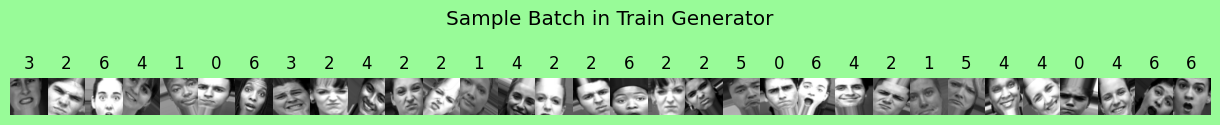

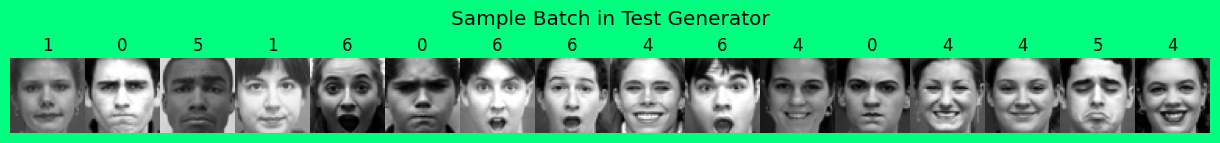

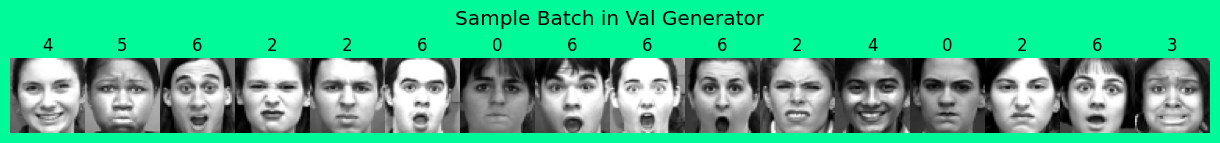

In [8]:
# Take a sample batch file
idx_train = random.randrange(len(train_generator))
idx_test = random.randrange(len(test_generator))
idx_val = random.randrange(len(val_generator))

# Displays an image with label for the train, test and val generator
list_train_img, list_train_lb = train_generator[idx_train]
list_test_img, list_test_lb = test_generator[idx_test]
list_val_img, list_val_lb = val_generator[idx_val]

# The number of images must be less than or equal to the batch size
def show_img_horizontal(title, color, list_img, list_lb, num_img):
  fig = plt.figure(figsize=(12,1.8), facecolor=color)
  fig.suptitle(title, fontsize='x-large')
  axs = fig.subplots(1, num_img)
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
  for i in range(num_img):
    axs[i].imshow(list_img[i])
    axs[i].axis('off')
    axs[i].title.set_text(np.argmax(list_lb[i]))

# Show image in train generator
show_img_horizontal(
    'Sample Batch in Train Generator',
    'palegreen',
    list_train_img,
    list_train_lb,
    batch_train
)
# Show image in test generator
show_img_horizontal(
    'Sample Batch in Test Generator',
    'springgreen',
    list_test_img,
    list_test_lb,
    batch_test
)
# Show image in test generator
show_img_horizontal(
    'Sample Batch in Val Generator',
    'mediumspringgreen',
    list_val_img,
    list_val_lb,
    batch_val
)

##Define Model with Basic CNN and DNN

In [9]:
# Basic Neural Network
model = tf.keras.models.Sequential([
    # CNN
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=size_input+(3,)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    # DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(7, activation="softmax")
])

model.summary()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001) #Default
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

###Training Model

In [10]:
history = model.fit(
    train_generator,
    epochs=40,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=1
)

Epoch 1/40
22/22 [==============================] - 22s 425ms/step - loss: 2.7753 - acc: 0.2142 - val_loss: 1.8287 - val_acc: 0.2552
Epoch 2/40
22/22 [==============================] - 11s 483ms/step - loss: 1.8311 - acc: 0.2533 - val_loss: 1.7946 - val_acc: 0.2483
Epoch 3/40
22/22 [==============================] - 8s 349ms/step - loss: 1.8089 - acc: 0.2388 - val_loss: 1.7918 - val_acc: 0.2828
Epoch 4/40
22/22 [==============================] - 11s 473ms/step - loss: 1.7686 - acc: 0.2764 - val_loss: 1.7145 - val_acc: 0.3034
Epoch 5/40
22/22 [==============================] - 8s 354ms/step - loss: 1.7650 - acc: 0.2692 - val_loss: 1.6495 - val_acc: 0.2759
Epoch 6/40
22/22 [==============================] - 11s 492ms/step - loss: 1.7001 - acc: 0.2880 - val_loss: 1.5938 - val_acc: 0.3310
Epoch 7/40
22/22 [==============================] - 9s 386ms/step - loss: 1.7152 - acc: 0.3054 - val_loss: 1.5708 - val_acc: 0.3655
Epoch 8/40
22/22 [==============================] - 11s 487ms/step - los

###Plot Accuracy and Lose

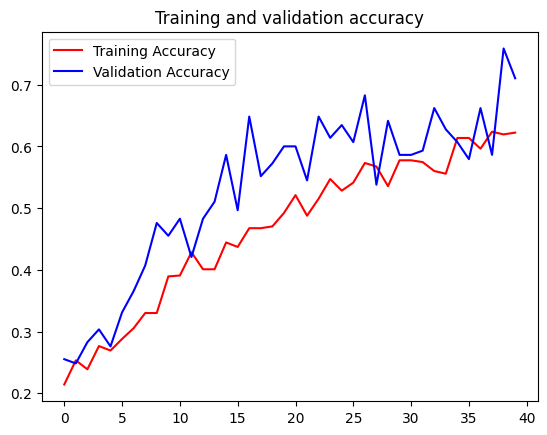

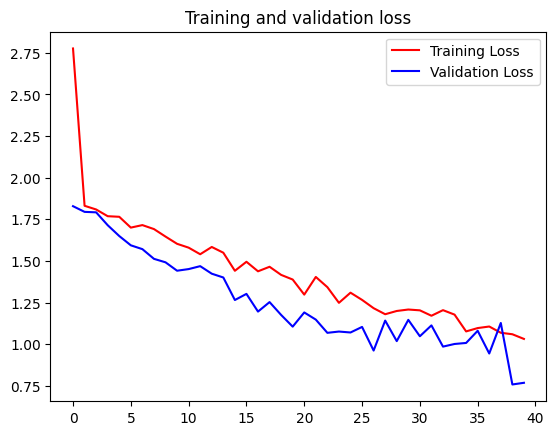

In [11]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and validation loss')
plt.legend()
plt.show()

###Test Accuracy Model

In [12]:
loss = model.evaluate(test_generator, steps=len(test_generator))

10/10 [==============================] - 0s 25ms/step - loss: 0.8757 - acc: 0.7172


##Improve Model with Transfer Learning (with MobileNet v2)

MobileNets, is one of the convolutional neural network (CNN) architectures that can be used to overcome the need for excessive computing resources.
Reference :


*   https://medium.com/nodeflux/mobilenet-deteksi-objek-pada-platform-mobile-bbbf3806e4b3
*   https://keras.io/api/applications/mobilenet/



###Create and Train Model

First, instantiate a base model with pre-trained weights.

In [13]:
# The base model is the model that is pre-trained.
# We will create a base model using MobileNet V2.

base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=size_input+(3,),
    include_top=False  # Do not include the ImageNet classifier at the top.
)

9406464/9406464 [==============================] - 0s 0us/step


Then, to implement fine-tuning of the whole base model, Unfreeze the base model.

In [14]:
# Unfreeze the base model
base_model.trainable = True

Create a new model on top.

In [15]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(7, activation='softmax')]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 7)                 8967      
                                                                 
Total params: 2266951 (8.65 MB)
Trainable params: 2232839 (8.52 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


Train the model on new data.

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), # Low learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

history = model.fit(
    train_generator,
    epochs=40,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=1
)

Epoch 1/40
22/22 [==============================] - 40s 609ms/step - loss: 2.1545 - categorical_accuracy: 0.1491 - val_loss: 2.1439 - val_categorical_accuracy: 0.2483
Epoch 2/40
22/22 [==============================] - 12s 536ms/step - loss: 2.0125 - categorical_accuracy: 0.2648 - val_loss: 2.1073 - val_categorical_accuracy: 0.2552
Epoch 3/40
22/22 [==============================] - 9s 401ms/step - loss: 1.8652 - categorical_accuracy: 0.3140 - val_loss: 2.0796 - val_categorical_accuracy: 0.2897
Epoch 4/40
22/22 [==============================] - 11s 507ms/step - loss: 1.7330 - categorical_accuracy: 0.3603 - val_loss: 2.0518 - val_categorical_accuracy: 0.3103
Epoch 5/40
22/22 [==============================] - 12s 538ms/step - loss: 1.6127 - categorical_accuracy: 0.4342 - val_loss: 1.9984 - val_categorical_accuracy: 0.3172
Epoch 6/40
22/22 [==============================] - 9s 399ms/step - loss: 1.5315 - categorical_accuracy: 0.4602 - val_loss: 1.9598 - val_categorical_accuracy: 0.3517


Plot Accuracy and Lose

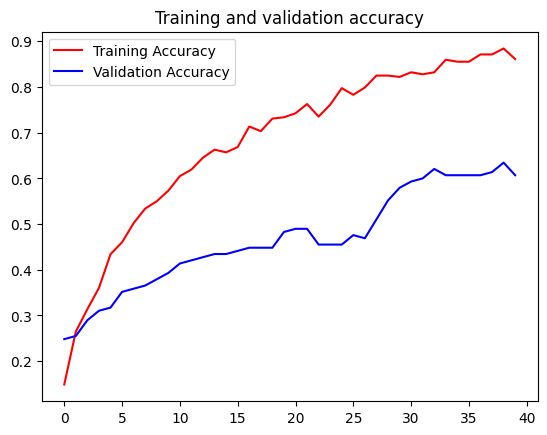

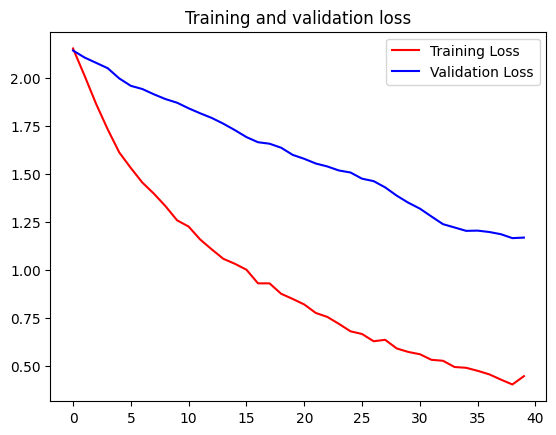

In [17]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and validation loss')
plt.legend()
plt.show()

###Test Accuracy Model

In [18]:
loss = model.evaluate(test_generator, steps=len(test_generator))

10/10 [==============================] - 0s 31ms/step - loss: 1.0507 - categorical_accuracy: 0.6828


###Visualize accuracy each label or class with confusion matrix

reference :
https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

In [19]:
# FIXED index order classes (https://github.com/keras-team/keras/issues/4225)
# Create new test generator with shuffle=False
new_test_generator = valtest_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=batch_test,
    class_mode='categorical',
    target_size=size_input,
    shuffle=False # important part
)
new_test_generator.classes

Found 145 images belonging to 7 classes.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int32)

In [20]:
predictions = model.predict(new_test_generator, steps=len(new_test_generator))

10/10 [==============================] - 1s 34ms/step


In [21]:
# [FIXED] Problem order classes with set shuffle=False in test_generator
predictions_lb = np.argmax(predictions,axis=1)

In [22]:
labels = new_test_generator.classes
confusion_matrix = tf.math.confusion_matrix(labels, predictions_lb)
print(confusion_matrix)

tf.Tensor(
[[17  3  0  0  0  0  0]
 [ 4  4  0  0  0  0  0]
 [ 3  0 23  0  0  0  0]
 [ 2  2  1  0  6  0  0]
 [ 1  2  0  0 28  0  0]
 [ 7  4  1  0  0  0  0]
 [ 3  7  0  0  0  0 27]], shape=(7, 7), dtype=int32)


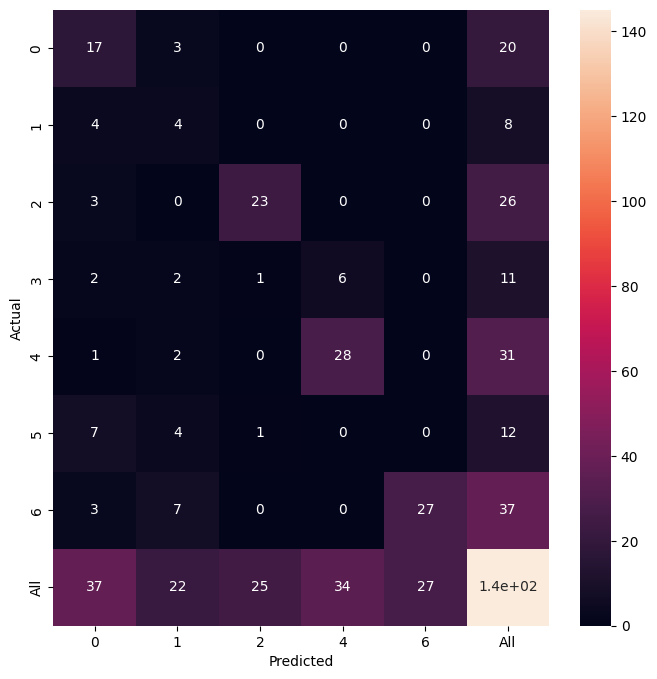

In [23]:
data = {'y_Actual': labels,
        'y_Predicted': predictions_lb
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)
plt.figure(figsize = (8,8))
sn.heatmap(confusion_matrix, annot=True)
plt.show()

More Details

In [24]:
report = metrics.classification_report(
    labels,
    predictions_lb,
    target_names=label
)
print(report)

              precision    recall  f1-score   support

       anger       0.46      0.85      0.60        20
    contempt       0.18      0.50      0.27         8
     disgust       0.92      0.88      0.90        26
        fear       0.00      0.00      0.00        11
       happy       0.82      0.90      0.86        31
     sadness       0.00      0.00      0.00        12
    surprise       1.00      0.73      0.84        37

    accuracy                           0.68       145
   macro avg       0.48      0.55      0.50       145
weighted avg       0.67      0.68      0.66       145



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Exporting and Optimization to TFLite

Reference :
https://huggingface.co/docs/transformers/tflite

In [25]:
# Specifies the model directory
model_dir = '/tmp/model'
try:
  os.mkdir(model_dir)
except OSError as e:
  print("\nUnable create directory. {}".format(e))

In [26]:
# Use the tf.saved_model API to save model in the SavedModel format
tf.saved_model.save(model, model_dir)

# Select mode of optimization
mode = "Default"

if mode == 'Storage':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
  optimization = tf.lite.Optimize.DEFAULT

Reference :
https://colab.research.google.com/github/tensorflow/examples/blob/master/lite/codelabs/digit_classifier/ml/step2_train_ml_model.ipynb#scrollTo=YvszGa11ne6Q

In [27]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 8694KBs.


In [28]:
# [FIXED] : Error when optimizing with the quantization method due to an error in the input type and there is no "converter.representative_dataset" section.
# ref : https://medium.com/sclable/model-quantization-using-tensorflow-lite-2fe6a171a90d
def represent_data_gen():
  "It yields an image one by one"
  for i in range(len(test_generator.filenames)):
    img_with_lb = test_generator.next()
    yield [np.array(img_with_lb[0], dtype=np.float32, ndmin=2)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [optimization]
converter.representative_dataset = represent_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Re-convert the model to TF Lite using quantization.
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model size = 2657KBs,
which is about 30% of the float model size.


In [29]:
interpreter = tf.lite.Interpreter(model_content=tflite_quantized_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


###Test and Evaluate Tflite Model with TFLite Interpreter (before download)

In [30]:
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # Run predictions on every image in the "test" dataset.
  predictions = []
  for test_image in list_test_img[:15]:

    # [FIXED] Input data type error, Previous error of type tf.float32, it should be tf.int8
    # Check if the input type is quantized, then rescale input data to uint8
    # ref : https://www.tensorflow.org/lite/performance/post_training_integer_quant
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    # Post-processing: remove batch dimension and find the digit with highest probability.
    predictions.append(output.argmax())

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(predictions)):
    if predictions[index] == np.argmax(list_test_lb[index]):
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(predictions)

  return accuracy

In [31]:
# Evaluate the TF Lite float model.
float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)

# Evalualte the TF Lite quantized model.
quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
gap_acc = float_accuracy - quantized_accuracy
if gap_acc >= 0:
  print('Accuracy drop = %.4f' % (gap_acc))
else:
  print('Accuracy increase = %.4f' % (-1*gap_acc))

Float model accuracy = 0.6667
Quantized model accuracy = 0.7333
Accuracy increase = 0.0667


###Download TFlite Model

Float Model

In [32]:
# Save the float model to file to the Downloads directory
f = open('/tmp/model/model-float-tl.tflite', "wb")
f.write(tflite_float_model)
f.close()

# Download the expression detection model
files.download('/tmp/model/model-float-tl.tflite')

print('`model-float-tl.tflite` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`model-float-tl.tflite` has been downloaded


Quantization Model

In [33]:
# Save the quantized model to file to the Downloads directory
f = open('/tmp/model/model-quant-tl.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the expression detection model
files.download('/tmp/model/model-quant-tl.tflite')

print('`model-quant-tl.tflite` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`model-quant-tl.tflite` has been downloaded
